## Ranking Neural Net

In [1]:
import torch 
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler
# import tensorboard
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import pearsonr

In [3]:
class PrismDataset(Dataset):
    def __init__(self, response_df, feature_df, feature_importance_df, top_k_features, slate_length, quantile_transfomer=None, prioritize_sensitive=True):
        self.response_df = response_df
        self.feature_df = feature_df
        self.feature_importance_df = feature_importance_df
        self.top_k_features = top_k_features
        self.slate_length = slate_length
        self.prioritize_sensitive = prioritize_sensitive
        
        # Get the top k features based on importance
        self.top_features = self.feature_importance_df.nlargest(top_k_features, "importance")["feature"].tolist()

        # filter self.feature_df to include only the top features
        self.feature_df = self.feature_df.loc[:, self.top_features]

        # quantile transform all features
        if not quantile_transfomer:
            self.quantile_transfomer = PowerTransformer()
            self.quantile_transfomer.fit(self.feature_df)
        else:
            self.quantile_transfomer = quantile_transfomer

        # quantile transform feature_df
        self.feature_df = pd.DataFrame(self.quantile_transfomer.transform(self.feature_df), columns=self.feature_df.columns, index=self.feature_df.index)

        # quantile transform labels
        self.label_transformer = MinMaxScaler()
        self.response_df["LFC.cb"] = self.label_transformer.fit_transform(self.response_df[["LFC.cb"]])
        if self.prioritize_sensitive:
            self.response_df.loc[:, "LFC.cb"] = 1 - self.response_df.loc[:, "LFC.cb"]
        # scale from 0 to 5
        self.response_df.loc[:, "LFC.cb"] = self.response_df.loc[:, "LFC.cb"] * 5

        # Join response_df and feature_df on "ccle_name"
        self.joined_df = pd.merge(self.response_df, self.feature_df, on="ccle_name")
        # set index to "ccle_name"
        self.joined_df = self.joined_df.set_index("ccle_name")

        # Order the columns
        self.cols = self.top_features + ["LFC.cb"]
        self.joined_df = self.joined_df.loc[:, self.cols]

        # impute missing values
        self.joined_df = self.joined_df.fillna(-1)

        # get ccle_names
        self.ccle_names = self.joined_df.index.tolist()

        if len(self.ccle_names) < self.slate_length:
            self.slate_length = len(self.ccle_names)

    def __len__(self):
        return len(self.ccle_names)

    def __getitem__(self, idx):
        # get slate_length - 1 samples from ccle_names
        index_name = self.ccle_names[idx]
        ccle_names = np.random.choice(self.ccle_names, self.slate_length - 1, replace=False).tolist()
        
        # get [index_name, *ccle_names] from joined_df
        samples = self.joined_df.loc[[index_name] + ccle_names, :]
        
        # Extract features and labels from the samples
        features = torch.tensor(samples.iloc[:, :-1].values, dtype=torch.float32)
        labels = torch.tensor(samples.iloc[:, -1].values.squeeze(), dtype=torch.float32)

        return features, labels


In [4]:
feature_path = "../../tests/data/test_features/x-all.pkl"
response_path = "../../tests/data/test_responses.csv"
feature_importance_path = "../../tests/data/test_output/cv/zotarolimus_BRD-K46843573-001-01-9_2.5_all_feature_importances.csv"

In [5]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [6]:
response_df = pd.read_csv(response_path)

In [7]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [8]:
ds = PrismDataset(response_df, feature_df, feature_importance_df, 100, 10)

In [9]:
ds[0]

(tensor([[ 1.4714e+00,  1.3802e+00, -2.5900e-01, -4.2906e-01,  6.9434e-02,
           3.1412e-01,  8.0025e-01,  1.1484e-01, -3.8037e-01, -4.9744e-01],
         [ 3.7871e-01, -6.4329e-01,  7.7255e-01, -9.8976e-02, -1.5545e+00,
          -6.6132e-01,  4.5016e-02,  1.6688e+00,  1.1770e-01, -4.9744e-01],
         [ 4.6631e-01, -8.8080e-01, -1.0844e+00,  1.6692e+00,  3.5613e-01,
           9.2983e-01, -1.9709e+00, -1.1399e+00, -2.9330e-01, -4.9744e-01],
         [ 5.1982e-01, -1.7757e-01, -2.5562e-01,  1.4340e+00, -5.9049e-02,
           4.6257e-01, -7.5445e-01,  1.8582e+00, -1.7053e-01, -4.9744e-01],
         [-9.7840e-01,  9.6001e-01,  1.7548e-01, -1.3467e+00,  9.3141e-01,
           3.8607e-01,  6.0835e-01, -1.1399e+00, -1.1620e-01, -4.9744e-01],
         [-3.0046e-01, -1.7002e-01,  7.0992e-01, -1.3467e+00,  2.0204e-01,
           1.1127e+00, -1.3744e+00, -6.3822e-01,  9.5158e-01, -4.9744e-01],
         [-1.6632e+00,  1.0783e-03,  2.8313e-01, -1.0968e+00,  1.6738e+00,
          -9.0909e-

In [10]:
import torch

PADDED_Y_VALUE = -1
DEFAULT_EPS = 1e-10


def lambdaLoss(y_pred, y_true, eps=DEFAULT_EPS, padded_value_indicator=PADDED_Y_VALUE, weighing_scheme=None, k=None, sigma=1., mu=10.,
               reduction="sum", reduction_log="binary"):
    """
    LambdaLoss framework for LTR losses implementations, introduced in "The LambdaLoss Framework for Ranking Metric Optimization".
    Contains implementations of different weighing schemes corresponding to e.g. LambdaRank or RankNet.
    :param y_pred: predictions from the model, shape [batch_size, slate_length]
    :param y_true: ground truth labels, shape [batch_size, slate_length]
    :param eps: epsilon value, used for numerical stability
    :param padded_value_indicator: an indicator of the y_true index containing a padded item, e.g. -1
    :param weighing_scheme: a string corresponding to a name of one of the weighing schemes
    :param k: rank at which the loss is truncated
    :param sigma: score difference weight used in the sigmoid function
    :param mu: optional weight used in NDCGLoss2++ weighing scheme
    :param reduction: losses reduction method, could be either a sum or a mean
    :param reduction_log: logarithm variant used prior to masking and loss reduction, either binary or natural
    :return: loss value, a torch.Tensor
    """
    device = y_pred.device
    y_pred = y_pred.clone()
    y_true = y_true.clone()

    padded_mask = y_true == padded_value_indicator
    y_pred[padded_mask] = float("-inf")
    y_true[padded_mask] = float("-inf")

    # Here we sort the true and predicted relevancy scores.
    y_pred_sorted, indices_pred = y_pred.sort(descending=True, dim=-1)
    y_true_sorted, _ = y_true.sort(descending=True, dim=-1)

    # After sorting, we can mask out the pairs of indices (i, j) containing index of a padded element.
    true_sorted_by_preds = torch.gather(y_true, dim=1, index=indices_pred)
    true_diffs = true_sorted_by_preds[:, :, None] - true_sorted_by_preds[:, None, :]
    padded_pairs_mask = torch.isfinite(true_diffs)

    if weighing_scheme != "ndcgLoss1_scheme":
        padded_pairs_mask = padded_pairs_mask & (true_diffs > 0)

    ndcg_at_k_mask = torch.zeros((y_pred.shape[1], y_pred.shape[1]), dtype=torch.bool, device=device)
    ndcg_at_k_mask[:k, :k] = 1

    # Here we clamp the -infs to get correct gains and ideal DCGs (maxDCGs)
    true_sorted_by_preds.clamp_(min=0.)
    y_true_sorted.clamp_(min=0.)

    # Here we find the gains, discounts and ideal DCGs per slate.
    pos_idxs = torch.arange(1, y_pred.shape[1] + 1).to(device)
    D = torch.log2(1. + pos_idxs.float())[None, :]
    maxDCGs = torch.sum(((torch.pow(2, y_true_sorted) - 1) / D)[:, :k], dim=-1).clamp(min=eps)
    G = (torch.pow(2, true_sorted_by_preds) - 1) / maxDCGs[:, None]

    # Here we apply appropriate weighing scheme - ndcgLoss1, ndcgLoss2, ndcgLoss2++ or no weights (=1.0)
    if weighing_scheme is None:
        weights = 1.
    else:
        weights = globals()[weighing_scheme](G, D, mu, true_sorted_by_preds)  # type: ignore

    # We are clamping the array entries to maintain correct backprop (log(0) and division by 0)
    scores_diffs = (y_pred_sorted[:, :, None] - y_pred_sorted[:, None, :]).clamp(min=-1e8, max=1e8)
    scores_diffs.masked_fill(torch.isnan(scores_diffs), 0.)
    weighted_probas = (torch.sigmoid(sigma * scores_diffs).clamp(min=eps) ** weights).clamp(min=eps)
    if reduction_log == "natural":
        losses = torch.log(weighted_probas)
    elif reduction_log == "binary":
        losses = torch.log2(weighted_probas)
    else:
        raise ValueError("Reduction logarithm base can be either natural or binary")

    if reduction == "sum":
        loss = -torch.sum(losses[padded_pairs_mask & ndcg_at_k_mask])
    elif reduction == "mean":
        loss = -torch.mean(losses[padded_pairs_mask & ndcg_at_k_mask])
    else:
        raise ValueError("Reduction method can be either sum or mean")

    return loss


def ndcgLoss1_scheme(G, D, *args):
    return (G / D)[:, :, None]


def ndcgLoss2_scheme(G, D, *args):
    pos_idxs = torch.arange(1, G.shape[1] + 1, device=G.device)
    delta_idxs = torch.abs(pos_idxs[:, None] - pos_idxs[None, :])
    deltas = torch.abs(torch.pow(torch.abs(D[0, delta_idxs - 1]), -1.) - torch.pow(torch.abs(D[0, delta_idxs]), -1.))
    deltas.diagonal().zero_()

    return deltas[None, :, :] * torch.abs(G[:, :, None] - G[:, None, :])


def lambdaRank_scheme(G, D, *args):
    return torch.abs(torch.pow(D[:, :, None], -1.) - torch.pow(D[:, None, :], -1.)) * torch.abs(G[:, :, None] - G[:, None, :])


def ndcgLoss2PP_scheme(G, D, *args):
    return args[0] * ndcgLoss2_scheme(G, D) + lambdaRank_scheme(G, D)


def rankNet_scheme(G, D, *args):
    return 1.


def rankNetWeightedByGTDiff_scheme(G, D, *args):
    return torch.abs(args[1][:, :, None] - args[1][:, None, :])


def rankNetWeightedByGTDiffPowed_scheme(G, D, *args):
    return torch.abs(torch.pow(args[1][:, :, None], 2) - torch.pow(args[1][:, None, :], 2))

In [11]:
import torch
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self, input_dim, dropout_prob=.3):
        super(FeedForwardNet, self).__init__()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [12]:
model = FeedForwardNet(10)

In [13]:
# create a torch dataloader around the dataset
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=3, shuffle=True)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
for epoch in range(10):
    for batch in dl:
        features, labels = batch
        pred_scores = model(features)
        loss = lambdaLoss(pred_scores.squeeze(), labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 10, loss.item()))

Epoch [1/10], Loss: 86.7914
Epoch [2/10], Loss: 88.7139
Epoch [3/10], Loss: 76.9281
Epoch [4/10], Loss: 85.0746
Epoch [5/10], Loss: 78.2002
Epoch [6/10], Loss: 65.4413
Epoch [7/10], Loss: 73.7721
Epoch [8/10], Loss: 80.1041
Epoch [9/10], Loss: 58.0144
Epoch [10/10], Loss: 54.7966


In [16]:
pred_scores.shape

torch.Size([2, 10, 1])

In [17]:
pred_scores

tensor([[[-0.3160],
         [-0.3245],
         [ 1.3830],
         [ 0.3862],
         [ 0.4164],
         [-0.0094],
         [ 0.6503],
         [ 0.4928],
         [ 0.6296],
         [-0.2887]],

        [[-0.6149],
         [ 2.8822],
         [-0.3150],
         [ 1.7872],
         [-0.5336],
         [-0.2763],
         [ 0.1509],
         [ 0.1958],
         [ 0.4029],
         [ 0.9636]]], grad_fn=<ViewBackward0>)

# Now do the same but train on the GPU with real data

In [18]:
feature_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_public-22q1-305b_v24/x-all.pkl"
response_path = "/mnt/c/Users/nick/Desktop/corsello_lab/data/depmap_repurposing/updated_responses/AMG-232.csv"
feature_importance_path = "/mnt/c/Users/nick/Desktop/corsello_lab/refract/notebooks/20230522_debug_weighted_models/data/baseline_rf/all/AMG-232_BRD-K64925568-001-01-8_2.5_all_feature_importances.csv"

In [19]:
import pickle
with open(feature_path, "rb") as f:
    feature_df = pickle.load(f)
# rename index as ccle_name
feature_df = feature_df.rename_axis("ccle_name")

In [20]:
response_df = pd.read_csv(response_path)

In [21]:
feature_importance_df = pd.read_csv(feature_importance_path)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
from sklearn.model_selection import KFold

In [24]:
splitter = KFold(n_splits=5, shuffle=True, random_state=42)

In [26]:
all_preds = []
all_true = []

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 200
BATCH_SIZE = 512

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features).squeeze()
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme", k=SLATE_LENGTH)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    model.eval()
    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1
Epoch [1/200], Loss: 667.9637
Epoch [2/200], Loss: 697.6080
Epoch [3/200], Loss: 757.5839
Epoch [4/200], Loss: 819.5173
Epoch [5/200], Loss: 845.5583
Epoch [6/200], Loss: 850.7545
Epoch [7/200], Loss: 851.7916
Epoch [8/200], Loss: 827.6008
Epoch [9/200], Loss: 814.4052
Epoch [10/200], Loss: 773.0935
Epoch [11/200], Loss: 743.0643
Epoch [12/200], Loss: 703.8342
Epoch [13/200], Loss: 683.5549
Epoch [14/200], Loss: 630.3212
Epoch [15/200], Loss: 594.7731
Epoch [16/200], Loss: 569.3141
Epoch [17/200], Loss: 529.0854
Epoch [18/200], Loss: 503.2720
Epoch [19/200], Loss: 464.8874
Epoch [20/200], Loss: 439.3223
Epoch [21/200], Loss: 403.3137
Epoch [22/200], Loss: 377.9250
Epoch [23/200], Loss: 356.8932
Epoch [24/200], Loss: 331.9363
Epoch [25/200], Loss: 315.2300
Epoch [26/200], Loss: 300.6483
Epoch [27/200], Loss: 288.2154
Epoch [28/200], Loss: 273.0696
Epoch [29/200], Loss: 275.8825
Epoch [30/200], Loss: 249.1973
Epoch [31/200], Loss: 254.5059
Epoch [32/200], Loss: 238.4843
Epoch [33/

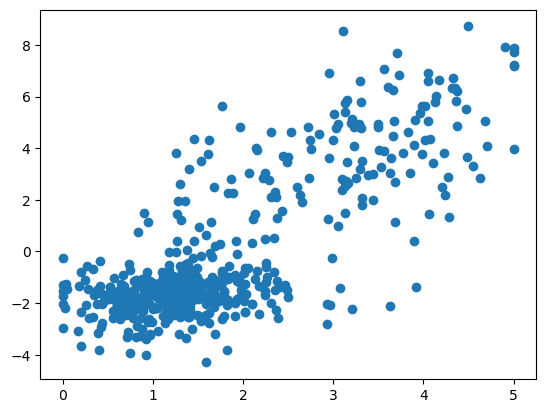

In [27]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [28]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.7895628350043554, 5.2849806182455915e-120)

In [29]:
df = pd.DataFrame({"preds": all_preds, "true": all_true})

In [30]:
df.head()
df["preds"] = QuantileTransformer().fit_transform(df[["preds"]]) * 5

/home/nphillips/miniconda3/envs/corlab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.
  warnings.warn(


In [31]:
# compute top 20 accuracy
def compute_accuracy_at_k(df, k_list=[1,5,10,20,50]):
    out = {}
    for k in k_list:
        df["preds_rank"] = df["preds"].rank(ascending=False)
        df["true_rank"] = df["true"].rank(ascending=False)

        df["preds_rank"] = df["preds_rank"].astype(int)
        df["true_rank"] = df["true_rank"].astype(int)

        df["top_true"] = df["true_rank"].apply(lambda x: 1 if x <= k else 0)
        df["top_pred"] = df["preds_rank"].apply(lambda x: 1 if x <= k else 0)
        out[k] = (df["top_pred"] & df["top_true"]).sum() / k
    return out

In [32]:
out = compute_accuracy_at_k(df)

In [33]:
out

{1: 0.0, 5: 0.4, 10: 0.5, 20: 0.45, 50: 0.54}

Text(0.5, 1.0, 'RF Model')

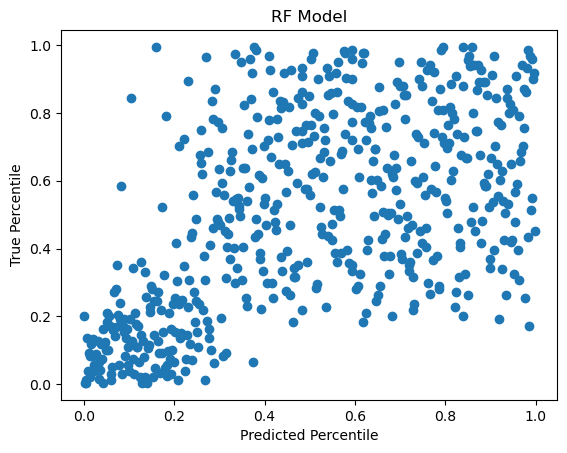

In [54]:
# compute pred_percentile
df["pred_percentile"] = df["preds"].rank(pct=True)
df["true_percentile"] = df["true"].rank(pct=True)

# plot
plt.scatter(1-df["pred_percentile"], 1-df["true_percentile"])
plt.xlabel("Predicted Percentile")
plt.ylabel("True Percentile")
plt.title("RF Model")

In [57]:
# compute residuals from x = y
df["residuals"] = df["pred_percentile"] - df["true_percentile"]

## SHAP explainer

In [58]:
# get some samples
X = []
y = []
for ex in ds_train:
    f, l = ex
    if l[0] > 4.5 or l[0] < 0.5:
        X.append(f[0,:])
        y.append(l[0])

In [59]:
X = torch.stack(X)

In [60]:
X = X.to(device)

In [61]:
X.shape

torch.Size([90, 100])

In [62]:
# expand middle dim
#X = X.unsqueeze(1)

In [63]:
X.shape

torch.Size([90, 100])

In [64]:
from shap import DeepExplainer

In [65]:
exp = DeepExplainer(model, X)

In [66]:
model(X).shape

torch.Size([90, 1])

In [67]:
shap_values = exp.shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [68]:
from shap import summary_plot

In [69]:
# get X as numpy array
X_np = X.cpu().numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


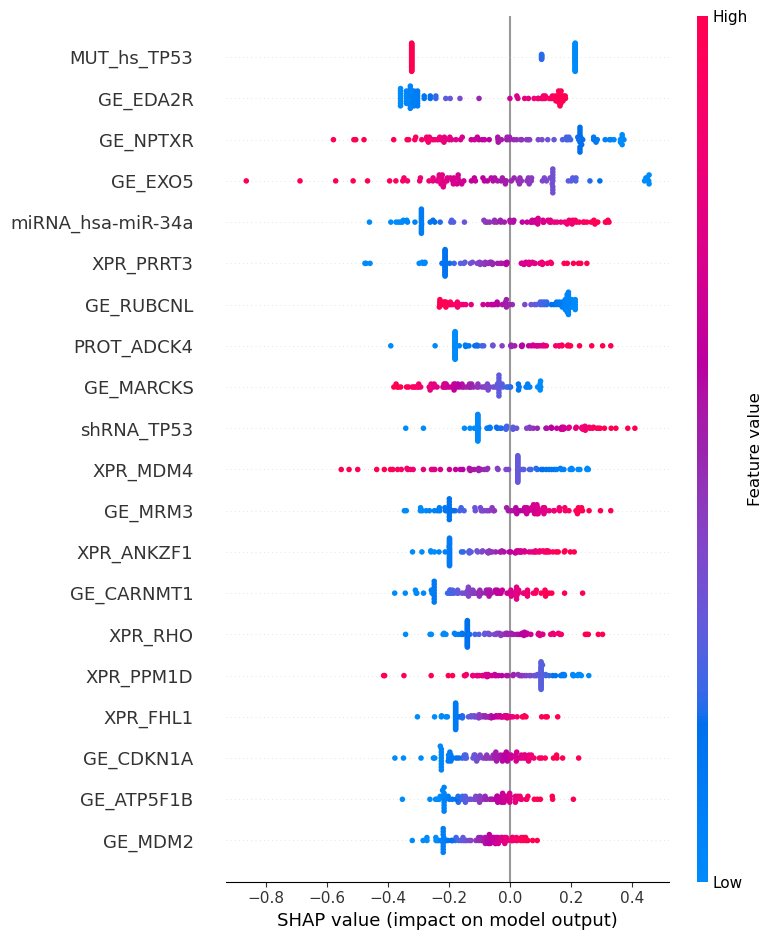

In [70]:
summary_plot(shap_values, X_np, feature_names=ds_train.joined_df.columns)

## Try another compound

In [72]:
response_df = pd.read_csv("../20230523_G9a_inhibitors/data/responses/BIX-01294.csv")
feature_importance_df = pd.read_csv("../20230523_G9a_inhibitors/data/output/BIX-01294/all/BIX-01294_BRD-K13060017-001-01-3_auc_all_feature_importances.csv")

In [73]:
all_preds = []
all_true = []

NUM_FEATURES = 100
SLATE_LENGTH = 10
NUM_EPOCHS = 250
BATCH_SIZE = 512

# create summary writer
writer = SummaryWriter()

for i, (train_index, test_index) in enumerate(splitter.split(response_df)):
    print(f"Fold {i+1}")
    response_train = response_df.iloc[train_index, :].copy()
    response_test = response_df.iloc[test_index, :].copy()
    ds_train = PrismDataset(response_train, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH)
    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

    model = FeedForwardNet(NUM_FEATURES)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(NUM_EPOCHS):
        for batch in dl_train:
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            pred_scores = model(features).squeeze()
            loss = lambdaLoss(pred_scores, labels, weighing_scheme="lambdaRank_scheme", k=SLATE_LENGTH)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
        writer.add_scalar("Loss/train", loss.item(), epoch)


    model.eval()
    train_preds = []
    train_true = []
    for ex in ds_train:
        f, l = ex
        pred = model(f.to(device))[0]
        train_preds.append(float(pred))
        train_true.append(float(l[0]))
    # compute pearsonr 
    train_pearsonr = pearsonr(train_preds, train_true)

    # test pred scores
    preds = []
    true = []
    ds_test = PrismDataset(response_test, feature_df, feature_importance_df, NUM_FEATURES, SLATE_LENGTH, quantile_transfomer=ds_train.quantile_transfomer)
    for ex in ds_test:
        f, l = ex
        pred = model(f.to(device))[0]
        preds.append(float(pred))
        true.append(float(l[0]))
    # compute pearsonr
    test_pearsonr = pearsonr(preds, true)
    writer.add_scalar("Pearsonr/train", train_pearsonr[0], i)
    writer.add_scalar("Pearsonr/test", test_pearsonr[0], i)

    # append to all preds
    all_preds.extend(preds)
    all_true.extend(true)

Fold 1


n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.


Epoch [1/250], Loss: 757.9622
Epoch [2/250], Loss: 769.0640
Epoch [3/250], Loss: 777.5060
Epoch [4/250], Loss: 770.3046
Epoch [5/250], Loss: 749.8500
Epoch [6/250], Loss: 734.6913
Epoch [7/250], Loss: 730.5063
Epoch [8/250], Loss: 712.7642
Epoch [9/250], Loss: 687.1239
Epoch [10/250], Loss: 672.3749
Epoch [11/250], Loss: 651.7310
Epoch [12/250], Loss: 653.2666
Epoch [13/250], Loss: 626.3939
Epoch [14/250], Loss: 606.1616
Epoch [15/250], Loss: 595.4055
Epoch [16/250], Loss: 575.6598
Epoch [17/250], Loss: 570.5704
Epoch [18/250], Loss: 569.8632
Epoch [19/250], Loss: 557.1130
Epoch [20/250], Loss: 550.2823
Epoch [21/250], Loss: 530.2131
Epoch [22/250], Loss: 533.5665
Epoch [23/250], Loss: 561.9025
Epoch [24/250], Loss: 557.1981
Epoch [25/250], Loss: 518.9230
Epoch [26/250], Loss: 513.1729
Epoch [27/250], Loss: 539.5989
Epoch [28/250], Loss: 505.9012
Epoch [29/250], Loss: 494.7451
Epoch [30/250], Loss: 526.1492
Epoch [31/250], Loss: 489.7193
Epoch [32/250], Loss: 486.4384
Epoch [33/250], L

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


Fold 2


n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.


Epoch [1/250], Loss: 723.0620
Epoch [2/250], Loss: 739.1008
Epoch [3/250], Loss: 772.7588
Epoch [4/250], Loss: 774.7659
Epoch [5/250], Loss: 776.0038
Epoch [6/250], Loss: 789.3239
Epoch [7/250], Loss: 768.7440
Epoch [8/250], Loss: 781.3467
Epoch [9/250], Loss: 752.6689
Epoch [10/250], Loss: 731.4728
Epoch [11/250], Loss: 730.3102
Epoch [12/250], Loss: 706.9365
Epoch [13/250], Loss: 697.0875
Epoch [14/250], Loss: 674.8051
Epoch [15/250], Loss: 650.7830
Epoch [16/250], Loss: 647.1638
Epoch [17/250], Loss: 628.1055
Epoch [18/250], Loss: 614.4265
Epoch [19/250], Loss: 588.6494
Epoch [20/250], Loss: 576.4935
Epoch [21/250], Loss: 573.2117
Epoch [22/250], Loss: 576.7534
Epoch [23/250], Loss: 573.7762
Epoch [24/250], Loss: 543.6428
Epoch [25/250], Loss: 545.3718
Epoch [26/250], Loss: 550.3207
Epoch [27/250], Loss: 513.3138
Epoch [28/250], Loss: 513.2435
Epoch [29/250], Loss: 528.7878
Epoch [30/250], Loss: 541.5651
Epoch [31/250], Loss: 529.7285
Epoch [32/250], Loss: 523.5571
Epoch [33/250], L

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


Fold 3


n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.


Epoch [1/250], Loss: 725.8118
Epoch [2/250], Loss: 740.8286
Epoch [3/250], Loss: 750.6545
Epoch [4/250], Loss: 756.7501
Epoch [5/250], Loss: 776.1041
Epoch [6/250], Loss: 772.6525
Epoch [7/250], Loss: 780.3872
Epoch [8/250], Loss: 763.3896
Epoch [9/250], Loss: 751.8589
Epoch [10/250], Loss: 754.7140
Epoch [11/250], Loss: 751.5704
Epoch [12/250], Loss: 730.2662
Epoch [13/250], Loss: 718.1946
Epoch [14/250], Loss: 702.2233
Epoch [15/250], Loss: 680.9454
Epoch [16/250], Loss: 666.6901
Epoch [17/250], Loss: 662.9017
Epoch [18/250], Loss: 631.7057
Epoch [19/250], Loss: 626.7064
Epoch [20/250], Loss: 600.1569
Epoch [21/250], Loss: 606.2988
Epoch [22/250], Loss: 577.7243
Epoch [23/250], Loss: 559.2610
Epoch [24/250], Loss: 572.3126
Epoch [25/250], Loss: 570.0055
Epoch [26/250], Loss: 549.1501
Epoch [27/250], Loss: 549.2573
Epoch [28/250], Loss: 524.4906
Epoch [29/250], Loss: 524.2630
Epoch [30/250], Loss: 524.0988
Epoch [31/250], Loss: 515.7506
Epoch [32/250], Loss: 521.1621
Epoch [33/250], L

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


Fold 4


n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.


Epoch [1/250], Loss: 717.0881
Epoch [2/250], Loss: 725.4645
Epoch [3/250], Loss: 757.9281
Epoch [4/250], Loss: 762.9551
Epoch [5/250], Loss: 794.1990
Epoch [6/250], Loss: 772.1094
Epoch [7/250], Loss: 785.4702
Epoch [8/250], Loss: 757.4496
Epoch [9/250], Loss: 753.6484
Epoch [10/250], Loss: 714.2260
Epoch [11/250], Loss: 710.4110
Epoch [12/250], Loss: 694.1654
Epoch [13/250], Loss: 681.9830
Epoch [14/250], Loss: 666.1036
Epoch [15/250], Loss: 629.9144
Epoch [16/250], Loss: 641.1216
Epoch [17/250], Loss: 610.9687
Epoch [18/250], Loss: 600.5968
Epoch [19/250], Loss: 588.5901
Epoch [20/250], Loss: 586.1357
Epoch [21/250], Loss: 569.9161
Epoch [22/250], Loss: 541.1555
Epoch [23/250], Loss: 549.5647
Epoch [24/250], Loss: 542.2401
Epoch [25/250], Loss: 560.7464
Epoch [26/250], Loss: 541.1097
Epoch [27/250], Loss: 524.4075
Epoch [28/250], Loss: 538.4725
Epoch [29/250], Loss: 546.2042
Epoch [30/250], Loss: 516.1029
Epoch [31/250], Loss: 505.6945
Epoch [32/250], Loss: 499.5191
Epoch [33/250], L

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


Fold 5


n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.


Epoch [1/250], Loss: 727.7790
Epoch [2/250], Loss: 764.7179
Epoch [3/250], Loss: 769.4147
Epoch [4/250], Loss: 778.2821
Epoch [5/250], Loss: 763.7279
Epoch [6/250], Loss: 766.6078
Epoch [7/250], Loss: 765.4844
Epoch [8/250], Loss: 727.7411
Epoch [9/250], Loss: 722.3098
Epoch [10/250], Loss: 681.1285
Epoch [11/250], Loss: 679.8085
Epoch [12/250], Loss: 650.6038
Epoch [13/250], Loss: 638.5648
Epoch [14/250], Loss: 615.5319
Epoch [15/250], Loss: 597.0851
Epoch [16/250], Loss: 580.9886
Epoch [17/250], Loss: 583.6345
Epoch [18/250], Loss: 548.7969
Epoch [19/250], Loss: 573.4823
Epoch [20/250], Loss: 540.1218
Epoch [21/250], Loss: 553.3680
Epoch [22/250], Loss: 531.4576
Epoch [23/250], Loss: 501.9562
Epoch [24/250], Loss: 510.4951
Epoch [25/250], Loss: 527.1720
Epoch [26/250], Loss: 506.9633
Epoch [27/250], Loss: 503.4585
Epoch [28/250], Loss: 480.4151
Epoch [29/250], Loss: 470.9883
Epoch [30/250], Loss: 485.7188
Epoch [31/250], Loss: 488.4637
Epoch [32/250], Loss: 496.5715
Epoch [33/250], L

n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.


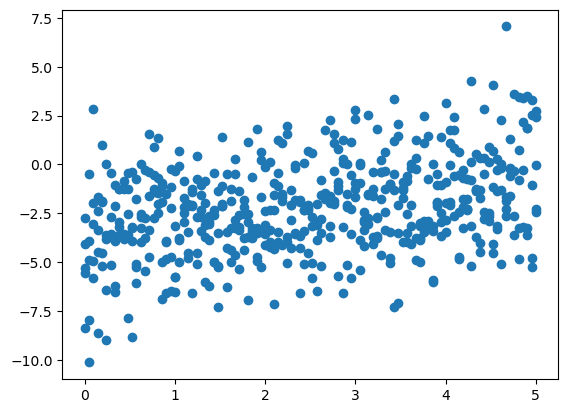

In [74]:
# plot all_preds vs all_true
import matplotlib.pyplot as plt
plt.scatter(all_true, all_preds)

In [75]:
# get pearson correlation all_preds vs all_true
from scipy.stats import pearsonr
pearsonr(all_true, all_preds)

(0.34482107709236903, 3.9350964819156573e-16)

In [76]:
df = pd.DataFrame({"preds": all_preds, "true": all_true})

In [77]:
df.head()
df["preds"] = QuantileTransformer().fit_transform(df[["preds"]]) * 5

n_quantiles (1000) is greater than the total number of samples (526). n_quantiles is set to n_samples.


In [78]:
out = compute_accuracy_at_k(df)

In [79]:
out

{1: 0.0, 5: 0.0, 10: 0.1, 20: 0.3, 50: 0.28}

Text(0.5, 1.0, 'RF Model')

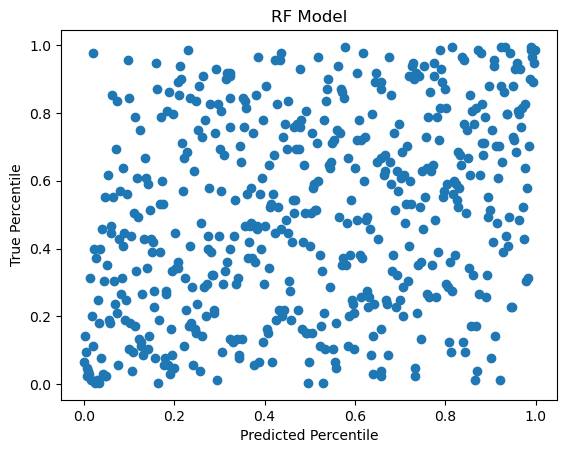

In [80]:
# compute pred_percentile
df["pred_percentile"] = df["preds"].rank(pct=True)
df["true_percentile"] = df["true"].rank(pct=True)

# plot
plt.scatter(1-df["pred_percentile"], 1-df["true_percentile"])
plt.xlabel("Predicted Percentile")
plt.ylabel("True Percentile")
plt.title("RF Model")

In [81]:
# get some samples
X = []
y = []
for ex in ds_train:
    f, l = ex
    if l[0] > 4.5 or l[0] < 0.5:
        X.append(f[0,:])
        y.append(l[0])

In [82]:
X = torch.stack(X)

In [83]:
X = X.to(device)

In [84]:
exp = DeepExplainer(model, X)

In [85]:
shap_values = exp.shap_values(X)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [86]:
# get X as numpy array
X_np = X.cpu().numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


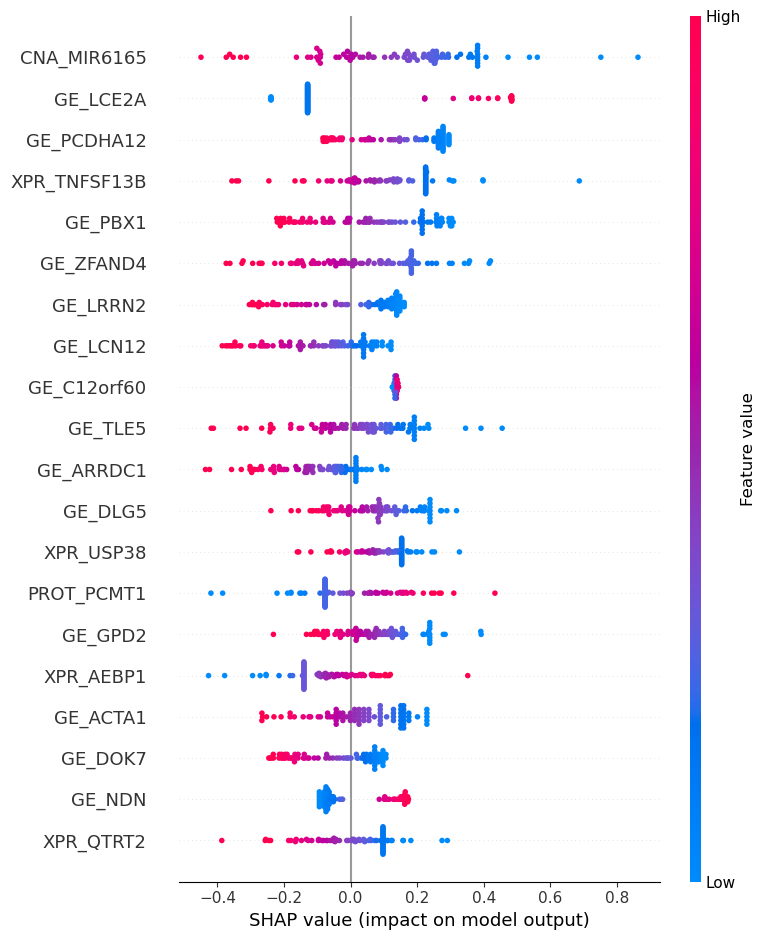

In [87]:
summary_plot(shap_values, X_np, feature_names=ds_train.joined_df.columns)